In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import pickle
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


In [2]:
df_bening = pd.read_csv('benign_traffic.csv')
df_bening.shape

(39100, 115)

In [3]:
scaler = MinMaxScaler()
df_bening = scaler.fit_transform(df_bening)

In [4]:
x_train, x_opt, x_test = np.split(df_bening, [int((1/3)*len(df_bening)), int((2/3)*len(df_bening))])
print(x_train.shape)
print(x_opt.shape)()
print(x_test.shape)

(13033, 115)
(13033, 115)
(13034, 115)


In [5]:
nb_epoch = 20
input_dim = x_train.shape[1]
learning_rate = 0.012

autoencoder = Sequential()
autoencoder.add(Dense(int(0.75 * input_dim), activation="tanh", input_dim=input_dim))
autoencoder.add(Dense(int(0.5 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.33 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.25 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.33 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.5 * input_dim), activation="tanh"))
autoencoder.add(Dense(int(0.75 * input_dim), activation="tanh"))
autoencoder.add(Dense(input_dim))

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
autoencoder.compile(loss='mean_squared_error',
                    optimizer='sgd')

cp = ModelCheckpoint(filepath="autoencoder_traffic_minmax.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(x_train, x_train,
                    epochs=nb_epoch,
                    validation_data=(x_opt, x_opt),
                    verbose=1,
                    callbacks=[cp, tb]).history

Instructions for updating:
Use tf.cast instead.
Train on 13033 samples, validate on 13033 samples
Epoch 1/20
13033/13033 [==============================] - 1s 49us/step - loss: 0.0840 - val_loss: 0.0398
Epoch 2/20
13033/13033 [==============================] - 1s 43us/step - loss: 0.0398 - val_loss: 0.0181
Epoch 3/20
13033/13033 [==============================] - 1s 42us/step - loss: 0.0230 - val_loss: 0.0120
Epoch 4/20
13033/13033 [==============================] - 1s 43us/step - loss: 0.0182 - val_loss: 0.0105
Epoch 5/20
13033/13033 [==============================] - 1s 38us/step - loss: 0.0167 - val_loss: 0.0100
Epoch 6/20
13033/13033 [==============================] - 1s 43us/step - loss: 0.0161 - val_loss: 0.0098
Epoch 7/20
13033/13033 [==============================] - 1s 43us/step - loss: 0.0156 - val_loss: 0.0096
Epoch 8/20
13033/13033 [==============================] - 1s 43us/step - loss: 0.0151 - val_loss: 0.0094
Epoch 9/20
13033/13033 [==============================] - 1s 4

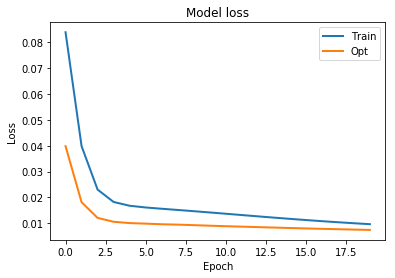

In [7]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Opt')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [8]:
x_opt_predictions = autoencoder.predict(x_opt)

In [9]:
mse = np.mean(np.power(x_opt - x_opt_predictions, 2), axis=1)
mse.shape

(13033,)

In [10]:
print(mse.mean())
print(mse.min())
print(mse.max())
print(mse.std())

0.0073638650958035455
0.0014934357186168526
0.23637811787252175
0.01246361474703028


In [11]:
tr = mse.mean() + mse.std()

In [12]:
x_test_predictions = autoencoder.predict(x_test)

In [13]:
mse_test = np.mean(np.power(x_test - x_test_predictions, 2), axis=1)
mse_test.shape

(13034,)

In [14]:
over_tr = mse_test > tr
false_positives = sum(over_tr)
print(false_positives)
fpr = false_positives / mse_test.shape[0]
print(fpr)

310
0.0237839496700936


In [15]:
false_alarms = 0
w = 82
for i in range(0, len(over_tr) - w):
  fp = sum(over_tr[i:i+w])
  if fp/2 > w:
    false_alarms = false_alarms + 1
    
print('False alarms %d' % false_alarms)

False alarms 0
